In [1]:
from autoregressive_lstm import QCMData
from bayesian_ridge import BayesianRidge
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.ndimage import uniform_filter, gaussian_filter
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [2]:
data = QCMData.import_hdf('data/Z-230203B.h5', 'data')

In [3]:
qcm = data.extract_rotations('s1', limits=(np.deg2rad(270), np.deg2rad(390)))

dqcm = np.diff(qcm)
mins = find_peaks(-dqcm)[0]
bgd = interp1d(mins, dqcm[mins], 'linear', fill_value='extrapolate')(np.arange(dqcm.size))

maxs = find_peaks(dqcm)[0]
maxs = maxs[dqcm[maxs] > 0.8 * (np.max(dqcm) - np.min(dqcm)) + np.min(dqcm)]
period = (maxs[1:] - maxs[:-1]).mean()

sgn = period * uniform_filter(dqcm - bgd, 1 * period, mode='nearest')[50:-50]

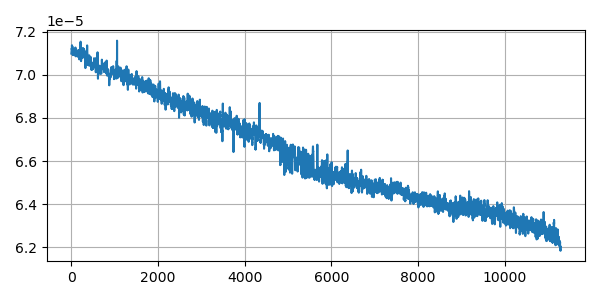

In [5]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 3))
# ax.plot(np.arange(dqcm.size), dqcm - bgd)
ax.plot(np.arange(sgn.size), sgn)
ax.grid(True)
fig.tight_layout()
plt.show()

# Tree Regressors

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import RegressorChain

lag = 500
overhead = 50

x_train = np.lib.stride_tricks.sliding_window_view(ddqcm[:5000], lag)
y_train = np.lib.stride_tricks.sliding_window_view(ddqcm[lag:5000 + overhead], overhead)

x_test = np.lib.stride_tricks.sliding_window_view(ddqcm[5000:6000], lag)
y_test = np.lib.stride_tricks.sliding_window_view(ddqcm[5000 + lag:6000 + overhead], overhead)

print(x_train.shape, y_train.shape)

rf_reg = RandomForestRegressor(max_depth=10, n_estimators=100)

gb_reg = RegressorChain(GradientBoostingRegressor(random_state=42))

rf_reg.fit(x_train, y_train)

In [ ]:
%matplotlib widget
idx = 10

pred_forest = np.stack([mdl.predict(x_train[[idx]])[0] for mdl in rf_reg.estimators_])
lower = np.quantile(pred_forest, 0.05, axis=0)
upper = np.quantile(pred_forest, 0.95, axis=0)

fig, ax = plt.subplots()
ax.plot(np.arange(idx, idx + lag), dqcm[idx] + np.cumsum(x_train[idx]), c='b')
ax.plot(np.arange(idx + lag, idx + lag + overhead) - 1,
        dqcm[lag + idx] + np.cumsum(np.append(0, y_train[idx]))[:-1],
        c='g', linestyle='dashed')
ax.plot(np.arange(idx + lag, idx + lag + overhead) - 1,
        dqcm[lag + idx] + np.cumsum(np.append(0, tree.predict(x_train[[idx]])[0]))[:-1], c='r')
ax.fill_between(np.arange(idx + lag, idx + lag + overhead) - 1,
                dqcm[lag + idx] + np.cumsum(np.append(0, lower))[:-1],
                dqcm[lag + idx] + np.cumsum(np.append(0, upper))[:-1], color='r', alpha=0.2)
fig.tight_layout()
plt.show()

In [ ]:
%matplotlib widget
idx = 40

pred_forest = np.stack([mdl.predict(x_test[[idx]])[0] for mdl in tree.estimators_])
lower = np.quantile(pred_forest, 0.05, axis=0)
upper = np.quantile(pred_forest, 0.95, axis=0)

fig, ax = plt.subplots()
ax.plot(np.arange(idx, idx + lag), dqcm[5000 + idx] + np.cumsum(x_test[idx]), c='b')
ax.plot(np.arange(idx + lag, idx + lag + overhead) - 1,
        dqcm[5000 + lag + idx] + np.cumsum(np.append(0, y_test[idx]))[:-1],
        c='b', linestyle='dashed')
ax.plot(np.arange(idx + lag, idx + lag + overhead) - 1,
        dqcm[5000 + lag + idx] + np.cumsum(np.append(0, tree.predict(x_test[[idx]])[0]))[:-1], c='r')
ax.fill_between(np.arange(idx + lag - 1, idx + lag + overhead - 1),
                dqcm[5000 + lag + idx] + np.cumsum(np.append(0, lower))[:-1],
                dqcm[5000 + lag + idx] + np.cumsum(np.append(0, upper))[:-1],
                color='r', alpha=0.2)
fig.tight_layout()
plt.show()

# Gaussian Process

## Jax

In [6]:
from jax.config import config

config.update("jax_enable_x64", True)

from jax import jit
import jax.numpy as jnp
import jax.random as jr
import gpjax as gpx
import optax as ox

import matplotlib as mpl
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [63]:
y = jnp.array(sgn).reshape(-1, 1) * 1e5
x = jnp.arange(y.size, dtype=jnp.float64).reshape(-1, 1) * 1e-3

dset = gpx.Dataset(x, y)

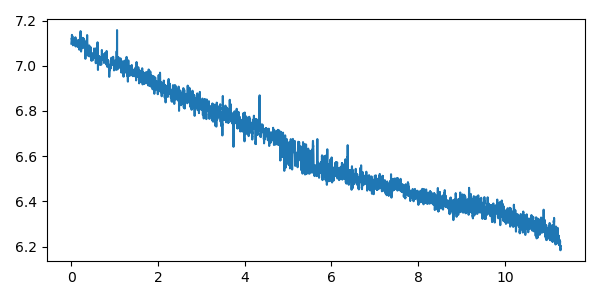

In [64]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x, y)
fig.tight_layout()
plt.show()

In [72]:
prior = gpx.Prior(mean_function=gpx.Constant(), kernel=gpx.Polynomial(degree=5, variance=1e-1))
likelihood = gpx.Gaussian(dset.n)
posterior = prior * likelihood

In [73]:
# negative_mll = gpx.objectives.ConjugateMLL(negative=True)
# negative_mll(posterior, train_data=dset)
# negative_mll = jit(negative_mll)

In [74]:
n_inducing = 50
z = jnp.linspace(x.min(), x.max(), n_inducing).reshape(-1, 1)

q = gpx.CollapsedVariationalGaussian(posterior=posterior, inducing_inputs=z)
elbo = gpx.CollapsedELBO(negative=True)
elbo = jit(elbo)

In [75]:
elbo(q, dset)

Array(10430.93490506, dtype=float64)

In [76]:
dset

- Number of observations: 11286
- Input dimension: 1
- Output dimension: 1

In [77]:
schedule = ox.cosine_onecycle_schedule(500, 3e-2)

opt_posterior, history = gpx.fit(model=q, objective=elbo,
                                 train_data=dset, optim=ox.adam(learning_rate=schedule),
                                 num_iters=500, key=jr.PRNGKey(0))

  0%|          | 0/500 [00:00<?, ?it/s]

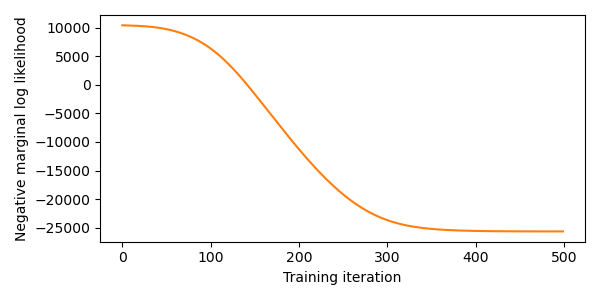

In [78]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(history, color=cols[1])
ax.set(xlabel="Training iteration", ylabel="Negative marginal log likelihood")
fig.tight_layout()
plt.show()

In [79]:
xtest = np.linspace(x.min(), x.max() + 3, 100)

latent_dist = opt_posterior.posterior.predict(xtest, train_data=dset)
predictive_dist = opt_posterior.posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

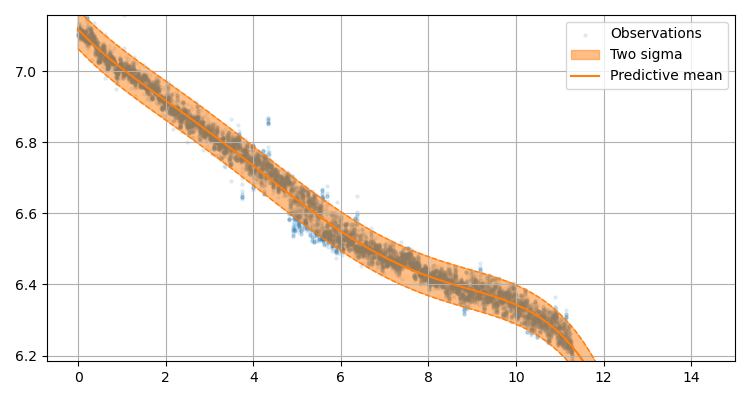

In [80]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(7.5, 4))
ax.scatter(x, y, label="Observations", s=5, color=cols[0], alpha=0.1)
ax.fill_between(xtest.squeeze(), predictive_mean - 2 * predictive_std, predictive_mean + 2 * predictive_std, alpha=0.5, label="Two sigma", color=cols[1])
ax.plot(xtest, predictive_mean - 2 * predictive_std, linestyle="--", linewidth=1, color=cols[1])
ax.plot(xtest, predictive_mean + 2 * predictive_std, linestyle="--", linewidth=1, color=cols[1])
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="upper right")

ax.grid(True)
ax.set_ylim(y.min(), y.max())
fig.tight_layout()
plt.show()

In [81]:
from dataclasses import dataclass
from gpjax.base import static_field
from gpjax.typing import ScalarInt

@dataclass
class WindowDataset():
    dset : gpx.Dataset
    window_size : ScalarInt = static_field(1)
    step_size : ScalarInt = static_field(1)
    lag : ScalarInt = static_field(0)

    def __len__(self) -> int:
        return (self.dset.n - self.window_size - self.step_size + self.lag) // self.step_size + 1
    
    def __getitem__(self, idx: int) -> gpx.Dataset:
        if idx >= self.__len__():
            raise IndexError

        start = idx * self.step_size
        lag = self.window_size - self.lag
        return (gpx.Dataset(self.dset.X[start:start + self.window_size],
                            self.dset.y[start:start + self.window_size]),
                gpx.Dataset(self.dset.X[start + lag:start + lag + self.step_size],
                            self.dset.y[start + lag:start + lag + self.step_size]))

In [82]:
opt_prior = opt_posterior.posterior.prior
opt_sigma = opt_posterior.posterior.likelihood.obs_noise

In [83]:
dset1

- Number of observations: 1
- Input dimension: 1
- Output dimension: 1

In [99]:
from tqdm import tqdm

window_size, step_size, lag = 1, 1, 0
windows = WindowDataset(gpx.Dataset(dset.X[:100], dset.y[:100]), window_size, step_size, lag)

train_dsets = []
new_dsets = []
for dset1, dset2 in tqdm(windows):
    train_dsets.append(dset1)
    latent_dist = opt_posterior.posterior.predict(dset2.X, train_data=np.sum(train_dsets))
    predictive_dist = opt_posterior.posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()
    new_dsets.append(gpx.Dataset(dset2.X, predictive_mean.reshape(-1, 1)))

100%|██████████| 99/99 [00:06<00:00, 15.68it/s]


In [100]:
new_dset = np.sum(new_dsets)
new_dset

- Number of observations: 99
- Input dimension: 1
- Output dimension: 1

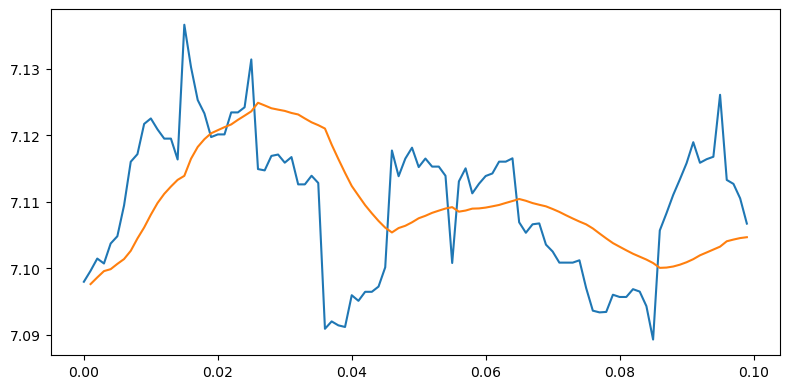

In [101]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(dset.X[:100], dset.y[:100])
ax.plot(new_dset.X, new_dset.y)

fig.tight_layout()
plt.show()

## scikit-learn

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, ExpSineSquared
from sklearn.model_selection import train_test_split

In [5]:
x = np.arange(dqcm.size)[:, None]
k0 = WhiteKernel(noise_level=0.5)

k1 = ConstantKernel(constant_value=0.5) * \
     ExpSineSquared(length_scale=1.0, periodicity=100, periodicity_bounds=(50, 200))

k2 = ConstantKernel(constant_value=0.5) * \
     RBF(length_scale=2e2, length_scale_bounds=(1e2, 1e3))

kernel = k0 + k2
model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)

In [7]:
x_train, y_train = x[:1000], dqcm[:1000]
x_test, y_test = x[1000:1500], dqcm[1000:1500]

In [8]:
model.fit(x_train, y_train)
params = model.kernel_.get_params()
params

{'k1': WhiteKernel(noise_level=1),
 'k2': 0.00316**2 * RBF(length_scale=998),
 'k1__noise_level': 1.0000098875155456,
 'k1__noise_level_bounds': (1e-05, 100000.0),
 'k2__k1': 0.00316**2,
 'k2__k2': RBF(length_scale=998),
 'k2__k1__constant_value': 9.999999999999997e-06,
 'k2__k1__constant_value_bounds': (1e-05, 100000.0),
 'k2__k2__length_scale': 998.3205863587126,
 'k2__k2__length_scale_bounds': (100.0, 1000.0)}

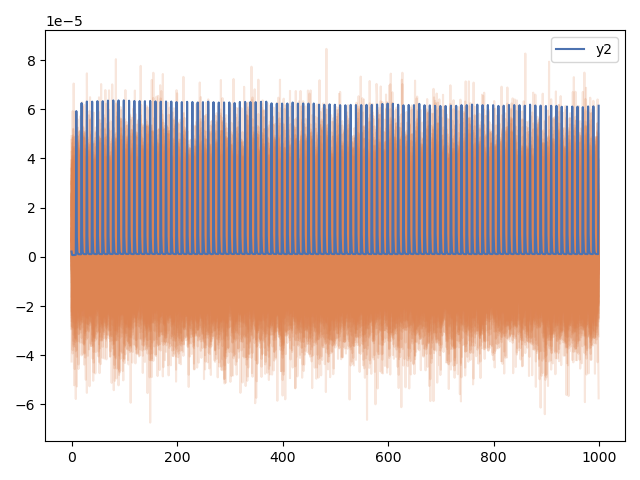

In [9]:
samples = model.sample_y(x_train, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=x_train[..., 0], y=samples[:, i], alpha=0.2, ax=ax,
                 color=sns.color_palette(palette='deep')[1])
sns.lineplot(x=x_train[..., 0], y=y_train, label='y2', ax=ax,
             color=sns.color_palette(palette='deep')[0]) 
fig.tight_layout()
plt.show()

In [10]:
y_pred, std = model.predict(np.concatenate((x_train, x_test)), return_std=True)

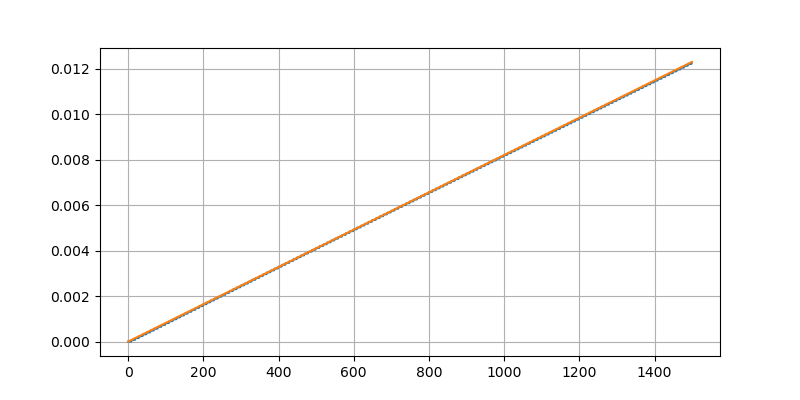

In [14]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(np.concatenate((x_train, x_test)), np.cumsum(np.concatenate((y_train, y_test))))
ax.plot(np.concatenate((x_train, x_test)), np.cumsum(y_pred))
ax.fill_between(np.concatenate((y_train, y_test)), y_pred - std, y_pred + std, alpha=0.1)
ax.grid(True)
plt.show()

# Bayesian Linear Regression

In [5]:
data = QCMData.import_hdf('data/Z-230203B.h5', 'data')
qcm = data.extract_rotations('s1', limits=(np.deg2rad(270), np.deg2rad(390)))

dqcm = np.diff(qcm)
mins = find_peaks(-dqcm)[0]
bgd = interp1d(mins, dqcm[mins], 'linear', fill_value='extrapolate')(np.arange(dqcm.size))

maxs = find_peaks(dqcm)[0]
maxs = maxs[dqcm[maxs] > 0.8 * (np.max(dqcm) - np.min(dqcm)) + np.min(dqcm)]
period = (maxs[1:] - maxs[:-1]).mean()

sgn = period * uniform_filter(dqcm - bgd, period, mode='nearest')

Y = sgn[15:-10]

## Polynomial fit

In [13]:
n_features = 5
max_idx = int(0.5 * Y.size)
# lambda_1, lambda_2 = None, None

X = np.linspace(0.0, 1.0, Y.size, endpoint=False)[:, None] ** np.arange(1, n_features + 1)[None, :]

Y_offset = np.mean(Y[:max_idx])
Y_scale = np.std(Y[:max_idx])
Y -= (Y[max_idx - 1] - Y[0]) * np.linspace(0.0, Y.size / max_idx, Y.size, endpoint=False)
Y = (Y - Y_offset) / Y_scale

breg = BayesianRidge(lambda_1=lambda_1, lambda_2=lambda_2).fit(X[:max_idx], Y[:max_idx])
# breg = BayesianRidge().fit(X[:max_idx], Y[:max_idx])

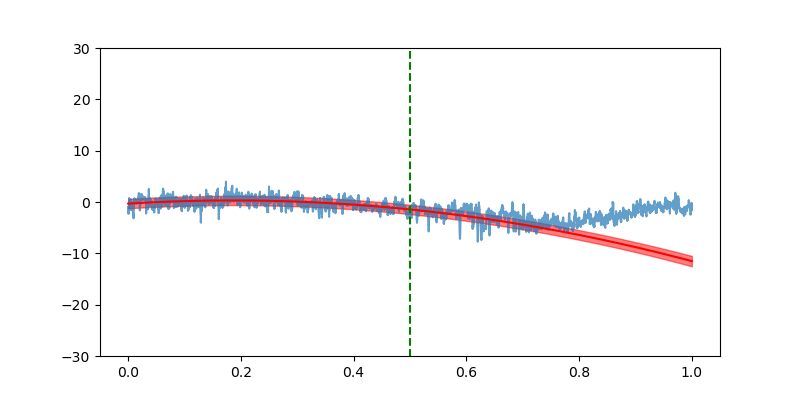

In [14]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))

mu, sigma = breg.predict(X, return_std=True)

ax.plot(X[:, 0], Y, alpha=0.7)
ax.plot(X[:, 0], mu, color='r')
ax.fill_between(X[:, 0], mu - sigma, mu + sigma, color='r', alpha=0.5)
ax.plot(X[max_idx - 1, 0] * np.ones(50), np.linspace(-40, 40), c='g', linestyle='dashed')

# ax.set_xlim(0.0, 2.0 * X[max_idx, 0])
# ax.set_xlim(0.0, 1.0)
ax.set_ylim(-30, 30)
plt.show()

In [9]:
n_features = 5
lambdas, alphas = [], []
for path in ['data/Z-230113B.h5', 'data/Z-230127B.h5', 'data/Z-230203B.h5', 'data/Z-230307B.h5']:
    data = QCMData.import_hdf(path, 'data')
    qcm = data.extract_rotations('s1', limits=(np.deg2rad(270), np.deg2rad(390)))

    dqcm = np.diff(qcm)
    mins = find_peaks(-dqcm)[0]
    bgd = interp1d(mins, dqcm[mins], 'linear', fill_value='extrapolate')(np.arange(dqcm.size))

    maxs = find_peaks(dqcm)[0]
    maxs = maxs[dqcm[maxs] > 0.8 * (np.max(dqcm) - np.min(dqcm)) + np.min(dqcm)]
    period = (maxs[1:] - maxs[:-1]).mean()

    sgn = period * uniform_filter(dqcm - bgd, period, mode='nearest')

    Y = sgn[15:-10]

    X = np.linspace(0, 1.0, Y.size, endpoint=False)[:, None] ** np.arange(1, n_features + 1)[None, :]
    Y_offset = np.mean(Y)
    Y_scale = np.std(Y)
    Y -= (Y[-1] - Y[0]) * X[:, 0]
    Y = (Y - Y_offset) / Y_scale

    breg = BayesianRidge().fit(X, Y)
    lambdas.append(breg.lambda_)
    alphas.append(breg.alpha_)
lambdas = np.stack(lambdas, axis=1)
alphas = np.array(alphas)

In [10]:
lambda_1 = np.mean(lambdas, axis=1)**2 / np.var(lambdas, axis=1)
lambda_2 = np.var(lambdas, axis=1) / np.mean(lambdas, axis=1)
print(lambda_1, lambda_2)

[0.51098092 1.54460362 2.02053477 1.62329401 1.15075004] [3.93683876e+00 7.25800564e-03 4.91227888e-04 4.42462510e-04
 4.56069132e-03]
